# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### Exploración de datos y Procesamiento del Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente.<br>
**Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

*Considero que el Proyecto podría entenderse como un problema de multi-clasificación, donde cada clase corresponde a un valor de estrella. No sería del todo preciso usar regresión porque no buscamos valores continuos, sino más bien discretos y que agrupen a las reseñas según el tipo de valoración que representan.*

## Objetivo del Proyecto
Implementar un modelo para reconocer el puntaje asignado por un usuario a un item de Amazon a partir de su crítica.

## Desarrollo
#### Importamos las librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Garbage collector para optimizar recursos
import gc

#### Importamos los datasets

In [11]:
# Importamos dataset de desarrollo
data_dev = pd.read_json("dataset_amazon/dataset_es_dev.json", lines = True)
print("- Cantidad de filas del set de desarrollo:", data_dev.shape[0])

# Importamos dataset de entrenamiento
data_train = pd.read_json("dataset_amazon/dataset_es_train.json", lines = True)
print("- Cantidad de filas del set de entrenamiento:", data_train.shape[0])

# Importamos dataset de prueba
data_test = pd.read_json("dataset_amazon/dataset_es_test.json", lines = True)
print("- Cantidad de filas del set de prueba:", data_test.shape[0])

- Cantidad de filas del set de desarrollo: 5000
- Cantidad de filas del set de entrenamiento: 200000
- Cantidad de filas del set de prueba: 5000


Como tanto el set de prueba como el de desarrollo son muy menores al set de entrenamiento (representa un <span style='color:red;'>**2,5%**</span> de los datos), vamos a juntar ambos datasets con el `train_test_split` y tomar un 30% para *test* más adelante. Esto además permite reducir la carga de entrenamiento.

In [12]:
# Concatenamos todos
data = pd.concat([data_dev,data_train,data_test])
data = data.reset_index(drop=True)
print("- Cantidad de filas del dataset:", data.shape[0])
print("- Cantidad de atributos (columnas) del dataset:", data.shape[1])

- Cantidad de filas del dataset: 210000
- Cantidad de atributos (columnas) del dataset: 8


Exploramos el dataset para entender los datos:

In [4]:
data.head()

,product_category,review_title,review_body,stars,revs_lemma,revs_stem
0,wireless,Mala compra,"Malisimo, muy grande demasiado aparatoso y mal...",1,malo compro malisimo grande aparatoso protecto...,mal compr malisim grand aparat protector pantall
1,apparel,No lo he recibido,No he recibido el pedido no la devolución,1,no recibir no recibir pedido no devolución,no recib no recib ped no devolu
2,sports,Que no aprieta bien en el manillar,"Tengo que buscar otro sistema, este no funcion...",1,no apretar manillar tener buscar sistema no fu...,no apriet manill teng busc sistem no funcion a...
3,home_improvement,Brocas de mantequilla,Utilicé las brocas de menor diámetro y se me d...,1,brocas mantequilla utilicé broca menor diámetr...,broc mantequill utilic broc menor diametr dobl...
4,beauty,No me gusta,No me gusta su olor a viejo y aspecto malo,1,no gustar no gustar olor viejo aspecto malo,no gust no gust olor viej aspect mal


In [13]:
data.tail()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
209995,es_0685611,product_es_0919143,reviewer_es_0461769,5,Para lo que cuesta es perfecto porque cumple s...,Perfectos para lo que sirven,es,wireless
209996,es_0638242,product_es_0636134,reviewer_es_0214562,5,"Material muy flexible y cómodo, acorde a la de...","Buen vendedor, rápido y fiable.",es,wireless
209997,es_0760108,product_es_0078583,reviewer_es_0043609,5,Se ve bien el grabado,medallas con bonito grabado,es,home
209998,es_0070806,product_es_0359350,reviewer_es_0258717,5,lo compré para mi bici pero finalmente se lo h...,timbre,es,sports
209999,es_0794544,product_es_0130307,reviewer_es_0651938,5,Pues este tipo de cascos si que son inalambric...,Auriculares sin cables de verdad,es,electronics


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210000 entries, 0 to 209999
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   review_id         210000 non-null  object
 1   product_id        210000 non-null  object
 2   reviewer_id       210000 non-null  object
 3   stars             210000 non-null  int64 
 4   review_body       210000 non-null  object
 5   review_title      210000 non-null  object
 6   language          210000 non-null  object
 7   product_category  210000 non-null  object
dtypes: int64(1), object(7)
memory usage: 12.8+ MB


In [15]:
# Para ver si hay nulos por columna
data.isna().sum()

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

#### Importamos librerías SpaCy y NLTK

Luego de investigar en la documentación de SpaCy y NLTK para ver cuáles stopwords eran más convenientes, vi que [SpaCy](https://github.com/explosion/spaCy/blob/master/spacy/lang/es/stop_words.py) era más completa que [NLTK](https://github.com/Alir3z4/stop-words/blob/bd8cc1434faeb3449735ed570a4a392ab5d35291/spanish.txt). Leyendo un poco sobre eso, descubrí que están sacadas del ámbito de las noticias y por eso tienen más vocabulario que forme parte de las 'stopwords'.

La librería NLTK es más acotada pero clásica, con palabras que bien podrían saltearse en un procesamiento de lenguaje natural. Lo que sí, ambas tienen palabras que nos podrían servir para predecir el valor de una reseña, como 'no', 'bueno', 'buena' y 'buen'.

Para este proyecto voy a elegir **SpaCy** por ser más completa, pero no descarto la posibilidad de entrenarlo con las stopwords de NLTK para evaluar si mejora en algo.

También iré alternando de librerías para los distintos procesos según la facilidad con la que se pueda utilizar cada una.

In [7]:
# Previamente
## python -m spacy download es
## python -m spacy download es_core_news_sm

import spacy # https://spacy.io/usage/models
nlp = spacy.load('es_core_news_sm')

#Stop Words de es_core_news_sm
from spacy.lang.es.stop_words import STOP_WORDS
stopwords_spacy = list(STOP_WORDS)

# Quitamos de las stopwords palabras como 'no', 'bueno', 'buena' que nos pueden ser últiles para predecir
stopwords_spacy.remove('no') # En los comentarios negativos es muy repetida
stopwords_spacy.remove('bueno')
stopwords_spacy.remove('buena')

In [8]:
import nltk

#Stop Words de nltk
from nltk.corpus import stopwords
stopwords_nltk = set(stopwords.words('spanish'))

# Quitamos de las stopwords la palabra 'no', que nos puede ser últil para predecir
stopwords_nltk.remove('no')

import re
from nltk.tokenize import RegexpTokenizer

## Análisis Exploratorio de Datos
#### Algunas preguntas que van surgiendo...
#### 1. ¿Cuántos tipos de productos hay en el dataset?

In [17]:
data.product_category.value_counts()

home                        28328
wireless                    27208
toy                         14328
sports                      13856
pc                          11720
home_improvement            11468
electronics                 10899
beauty                       7707
automotive                   7495
kitchen                      7028
apparel                      6014
drugstore                    5778
book                         5528
furniture                    5481
baby_product                 5098
office_product               5010
lawn_and_garden              4449
other                        4131
pet_products                 3899
personal_care_appliances     3735
luggage                      3509
camera                       3180
shoes                        2886
digital_ebook_purchase       1936
video_games                  1818
jewelry                      1677
musical_instruments          1608
watch                        1567
industrial_supplies          1552
grocery       

#### 2. ¿Cuántas reseñas hay por cada estrella según la categoría?

In [25]:
data_grouped = data.review_id.groupby([data['product_category'],data['stars']]).count().astype(int).reset_index(name='count')
data_grouped

,product_category,stars,count
0,apparel,1,1324
1,apparel,2,1271
2,apparel,3,1263
3,apparel,4,1177
4,apparel,5,979
...,...,...,...
145,wireless,1,6605
146,wireless,2,5972
147,wireless,3,5046
148,wireless,4,4844


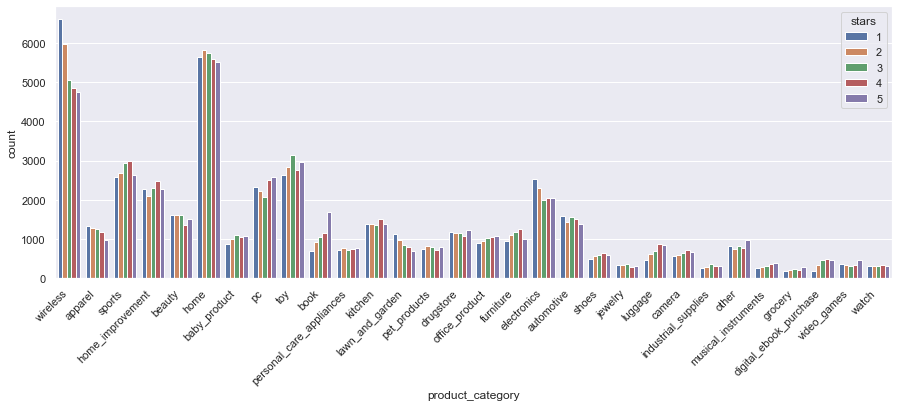

In [37]:
# Visualización
plt.figure(figsize=(15,5))
grafico = sns.countplot(x=data['product_category'],data=data, hue='stars')
grafico.set_xticklabels(grafico.get_xticklabels(), rotation=45, ha="right")
plt.show()

#### 3. ¿Cuál es el promedio de estrellas por cada categoría? <br>
*La media debería dar alrededor de 3, pero aquellos que estén por debajo significa que fueron en su mayoría peor calificados. Inversamente sucede con los que están por encima de 3, lo que significa que fueron en su mayoría muy bien calificados.*

In [38]:
from statistics import mean
data_grouped = data.stars.groupby([data['product_category']]).mean().reset_index(name='avg_stars')
data_grouped['rev_count'] = data.stars.groupby([data['product_category']]).count().astype(int).reset_index(name='rev_count').rev_count
data_grouped.sort_values(by='avg_stars')

,product_category,avg_stars,rev_count
16,lawn_and_garden,2.763093,4449
29,wireless,2.821523,27208
0,apparel,2.869638,6014
8,electronics,2.891091,10899
14,jewelry,2.929636,1677
3,beauty,2.940574,7707
1,automotive,2.955704,7495
11,home,2.982526,28328
28,watch,2.994895,1567
23,pet_products,2.996409,3899


##### Visualización

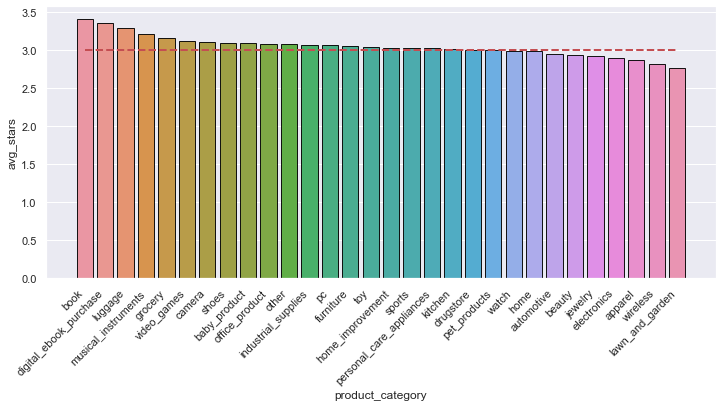

In [39]:
# Visualización de valoración promedio por categoría
data_grouped.sort_values(['avg_stars','rev_count'],ascending=False,inplace=True)
cte = np.ones(data_grouped.shape[0])*3 # Valor medio
plt.figure(figsize=(12,5))
grafico = sns.barplot(x=data_grouped.product_category, y=data_grouped.avg_stars, linewidth=0.9,edgecolor=(0,0,0))
plt.plot(cte, ls = '--', lw = 2, c='r',label = 'Valoración media')
grafico.set_xticklabels(grafico.get_xticklabels(), rotation=45, ha="right")
plt.show()

#### 4. ¿Cuántas reseñas hay por cada categoría? <br>
*Esto nor permitirá dar contexto a los promedios previamente obtenidos.*

<AxesSubplot:title={'center':'Cantidad de reviews por categoría'}, xlabel='Categoría', ylabel='Cantidad de reseñas'>

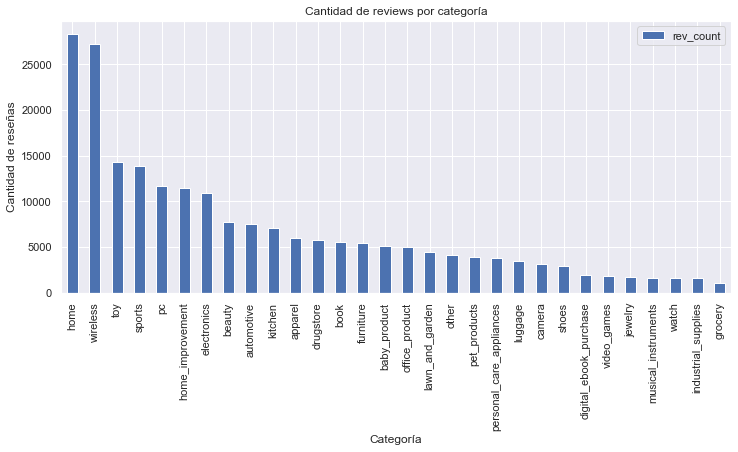

In [49]:
data_grouped.sort_values(by='rev_count',ascending=False).plot(x='product_category',y='rev_count',kind='bar',figsize=(12,5),title='Cantidad de reviews por categoría', xlabel='Categoría', ylabel='Cantidad de reseñas')

#### 5. ¿Cuántas reviews hay por cada valoración?

In [50]:
data.stars.value_counts()

1    42000
2    42000
3    42000
4    42000
5    42000
Name: stars, dtype: int64

*Vemos que está equilibrada la cantidad de cada una.*

#### 6. ¿Cuántos usuarios únicos publicaron en este dataset?

In [51]:
# Ver cuántos usuarios únicos publicaron
unique_usrs = len(data.reviewer_id.unique())
print("De las", data.shape[0],"reseñas,", unique_usrs, "fueron hechas por usuarios únicos.")
print("Esto equivale al", unique_usrs/data.shape[0]*100,"%")

De las 210000 reseñas, 187140 fueron hechas por usuarios únicos.
Esto equivale al 89.11428571428571 %


#### 7. ¿Cuántos productos únicos aparecen en las reseñas?

In [52]:
# Ver sobre cuántos productos únicos se publicaron reseñas
unique_prods = len(data.product_id.unique())
print("De las", data.shape[0],"reseñas, se mencionan", unique_prods , "productos únicos.")
print("Esto equivale al", unique_prods/data.shape[0]*100,"%")

De las 210000 reseñas, se mencionan 156458 productos únicos.
Esto equivale al 74.50380952380952 %


#### 8. Tomamos como ejemplo un usuario y analizamos su actividad

In [53]:
# Vemos las reseñas de un solo usuario
rand_idx = np.random.randint(0,data.shape[0])
usr = data.reviewer_id.iloc[rand_idx]
usr_data = data[data.reviewer_id == usr]
print("Cantidad de reseñas del usuario", usr,":", len(usr_data))
print("Promedio de estrellas que ha dado:", usr_data.stars.mean())
usr_data[['reviewer_id','product_category','review_title','review_body','stars']]

Cantidad de reseñas del usuario reviewer_es_0738031 : 1
Promedio de estrellas que ha dado: 2.0


,reviewer_id,product_category,review_title,review_body,stars
69179,reviewer_es_0738031,toy,No le ha gustado,Es más pequeño de lo que parece,2


In [54]:
print(usr_data.review_title)

69179    No le ha gustado
Name: review_title, dtype: object


In [55]:
usr_data.review_body.iloc[0]

'Es más pequeño de lo que parece'

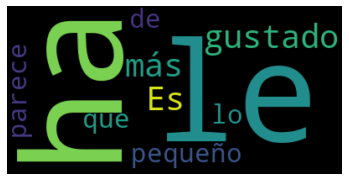

In [56]:
# pip install wordcloud
from wordcloud import WordCloud
wordcloud = WordCloud().generate(usr_data.review_title.iloc[0] + ' ' + usr_data.review_body.iloc[0])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

*Con una review no es tan eficiente el Wordcloud para visualizar ya que puede no haber palabras repetidas. Buscamos entonces juntar más reviwes de un mismo tipo*

#### 9. ¿Cuáles son las palabras más frecuentes por cada valoración?
Para responder a esto utilizmos la librería spaCy para el procesamiento del lenguaje natural.

In [57]:
# Separamos en distintos dataframes las reviews según valoración
data_star_1 = data[data['stars']==1]
data_star_2 = data[data['stars']==2]
data_star_3 = data[data['stars']==3]
data_star_4 = data[data['stars']==4]
data_star_5 = data[data['stars']==5]

<span style='color:purple;'>**Empezamos analizando las reviews de 1 estrella:**</span>
<br> Vamos a quedarnos sólo con los adjetivos para mejorar la visualización.

In [60]:
todas_reviews_1 = []
for i in data_star_1.index:
    review1 = data_star_1.review_body[i] #seleccionar el titular
    sent = nlp(review1.lower())
    for token in sent:
        if (token.pos_ == "ADJ" and token.text not in stopwords_spacy):
            temp = token.lemma_
            todas_reviews_1.append(temp) #agregar el resultado a la lista

print('- Cantidad de palabras filtradas:',len(todas_reviews_1))
todas_reviews_1[:3]

- Cantidad de palabras filtradas: 70778


['malisimo', 'grande', 'aparatoso']

In [61]:
# Obtenemos frecuencia de palabras y creamos nuevo df
freq_rev_1 = nltk.FreqDist(todas_reviews_1)
df_rev_frec_1 = pd.DataFrame(freq_rev_1.items(), columns = ['Palabra', 'Frecuencia']) 
df_rev_frec_1.sort_values(by=['Frecuencia'], inplace=True, ascending=False)
df_rev_frec_1.reset_index(drop = True, inplace=True)
df_rev_frec_1.head()

,Palabra,Frecuencia
0,malo,3750
1,pequeño,1890
2,roto,1530
3,amazon,1157
4,buen,915


In [62]:
# Vemos la parte inferior
df_rev_frec_1[df_rev_frec_1['Frecuencia']<10]

,Palabra,Frecuencia
853,súper,9
854,luminoso,9
855,aplicado,9
856,iluminado,9
857,plastificado,9
...,...,...
5964,xr,1
5965,atresmedio,1
5966,revell,1
5967,bicomponente,1


##### Visualizamos la frecuencia de las palabras en las reviews de 1 estrella

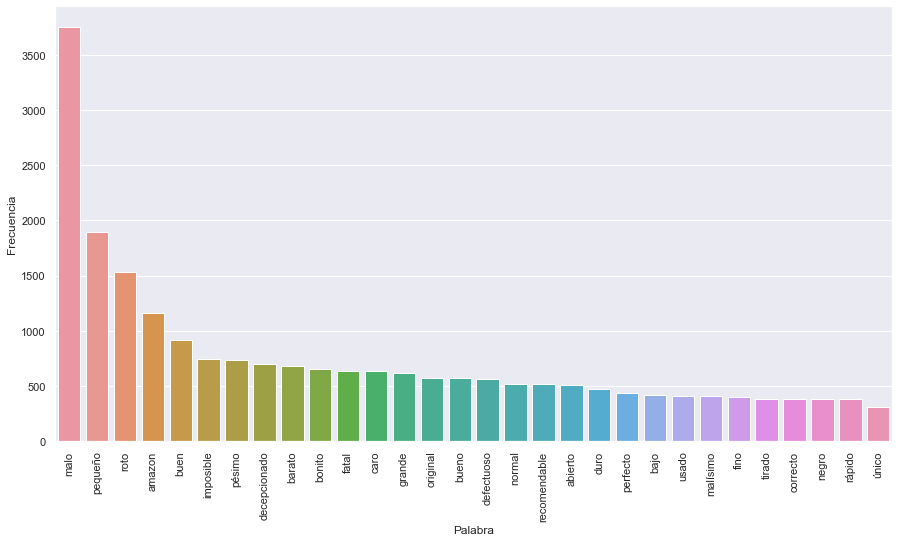

In [63]:
# Generamos gráfico con valores
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_rev_frec_1.iloc[:30].Palabra, y = df_rev_frec_1.iloc[:30].Frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

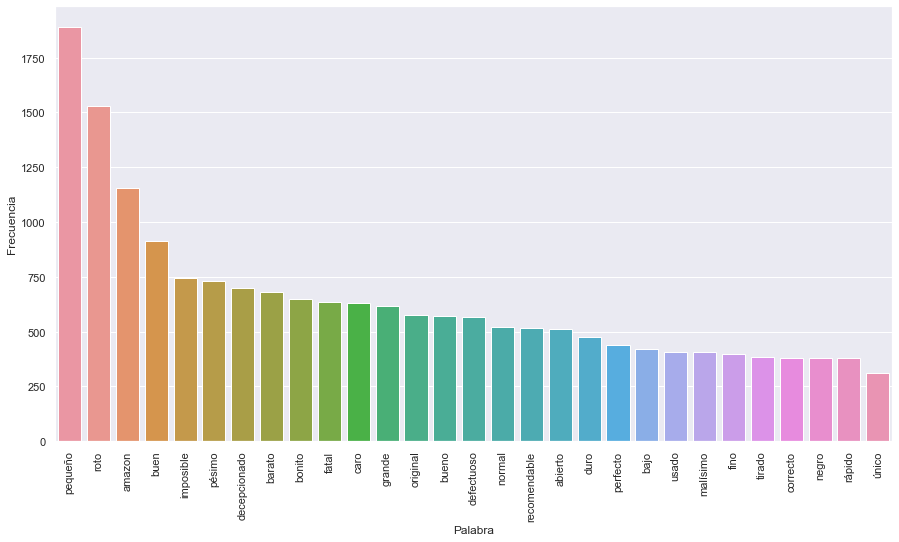

In [64]:
# Filtramos la palabra 'no' que es ampliamente más frecuente para visualizar mejor
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_rev_frec_1.iloc[1:30].Palabra, y = df_rev_frec_1.iloc[1:30].Frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

In [65]:
from wordcloud import WordCloud

# Definimos función para ver el wordcloud de una lista de palabras
def ver_wordcloud(palabras):
    text = ' '.join(palabras)
    wordcloud = WordCloud().generate(text.strip())
    plt.figure(figsize = (15,8), facecolor = None)
    plt.imshow(wordcloud, interpolation='kaiser')
    plt.axis("off")
    plt.show()

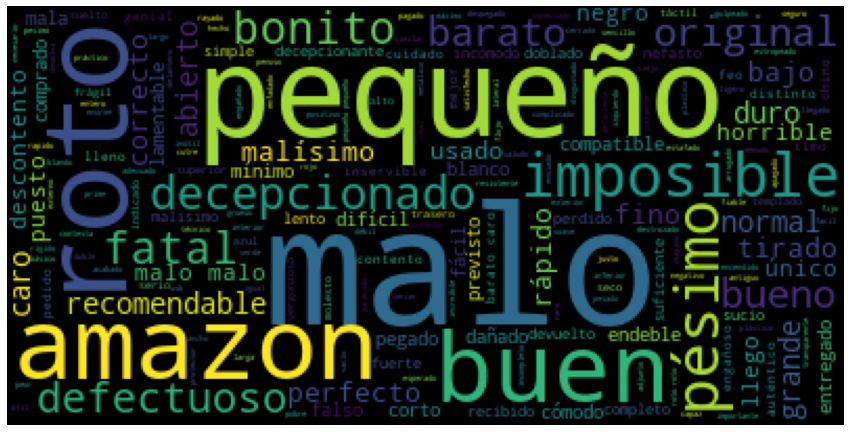

In [69]:
ver_wordcloud(todas_reviews_1)

*Palabras como 'Amazon', 'primero' y 'segundo' se repiten mucho pero no son relevantes.*

##### Abstracción
Para procesar los restantes dataframes, abstraemos todas las operaciones en dos funciones:

In [72]:
def adj_list(dataframe):
    todas_reviews = []
    for i in dataframe.index:
        review1 = dataframe.review_body[i] #seleccionar el titular
        sent = nlp(review1.lower())
        # review1 = RegexpTokenizer('\w+').tokenize(review1) # Tokenizar con RegexpTokenizer
        for token in sent:            
            if (token.pos_ == "ADJ" and str(token) not in stopwords_spacy):
                temp = token.lemma_
                todas_reviews.append(temp) #agregar el resultado a la lista
    return todas_reviews

def adj_frecquency_df(todas_reviews):
    # plain_todas_reviews = list(itertools.chain(*todas_reviews)) # Aplanar la lista
    freq_revs = nltk.FreqDist(todas_reviews) # Obtener frecuencia por palabra
    df_revs = pd.DataFrame(freq_revs.items(), columns = ['Palabra', 'Frecuencia']) # Crear nuevo df
    df_revs.sort_values(by=['Frecuencia'], inplace=True, ascending=False) # Ordenar valores por frecuencia
    df_revs.reset_index(drop = True, inplace=True) # Resetear index
    return df_revs

<span style='color:purple;'>**Analizamos las reviews de 5 estrellas:**</span>

In [73]:
# Listamos los adjetivos de las reviews con 5 estrellas
todas_reviews_5 = adj_list(data_star_5)

In [74]:
df_rev_frec_5 = adj_frecquency_df(todas_reviews_5)
df_rev_frec_5

,Palabra,Frecuencia
0,perfecto,7180
1,buen,7157
2,fácil,2720
3,bonito,2674
4,genial,2592
...,...,...
6100,kirby,1
6101,collarin,1
6102,corrector,1
6103,disfrutable,1


##### Visualizamos la frecuencia de las palabras en las reviews de 5 estrellas

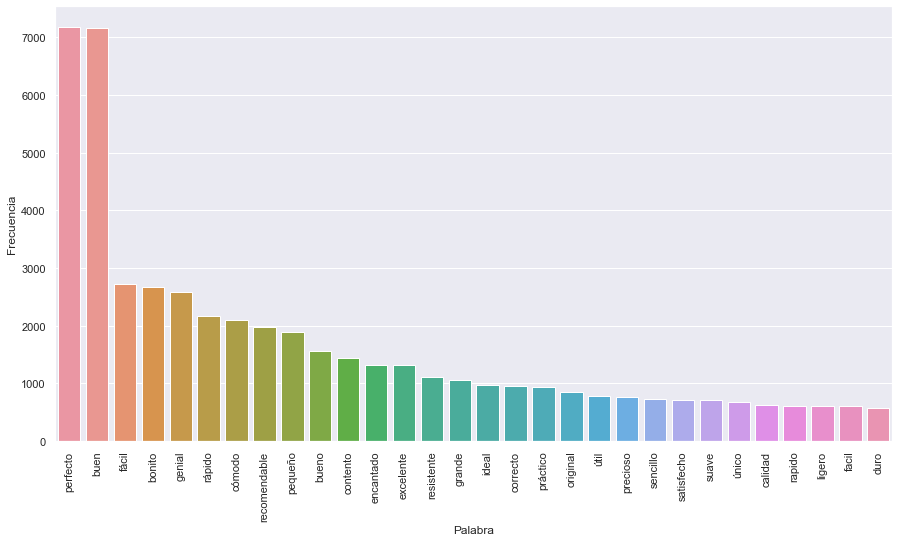

In [78]:
# Generamos gráfico con valores
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_rev_frec_5.iloc[:30].Palabra, y = df_rev_frec_5.iloc[:30].Frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

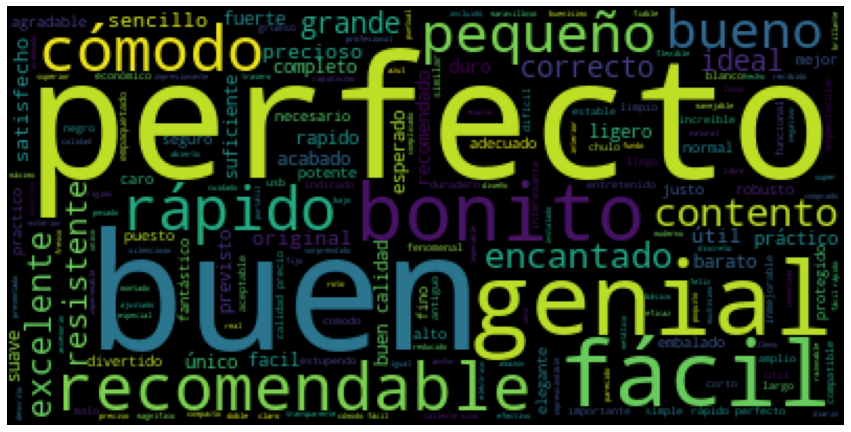

In [79]:
ver_wordcloud(todas_reviews_5)

<span style='color:purple;'>**Como punto medio, analizamos las reviews de 3 estrellas:**</span>

In [82]:
# Listamos los adjetivos de las reviews con 3 estrellas
todas_reviews_3 = adj_list(data_star_3)

In [83]:
df_rev_frec_3 = adj_frecquency_df(todas_reviews_3)
df_rev_frec_3

,Palabra,Frecuencia
0,pequeño,3714
1,buen,3356
2,bonito,2449
3,bueno,1762
4,grande,1698
...,...,...
6406,geométrico,1
6407,flamante,1
6408,conclusión,1
6409,adornado,1


##### Visualizamos la frecuencia de las palabras en las reviews de 3 estrellas

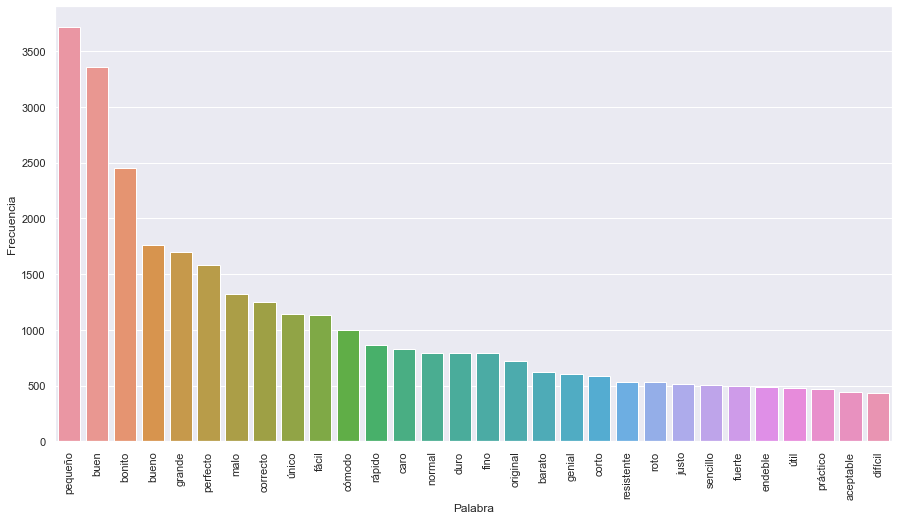

In [85]:
# Generamos gráfico con valores
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_rev_frec_3.iloc[:30].Palabra, y = df_rev_frec_3.iloc[:30].Frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

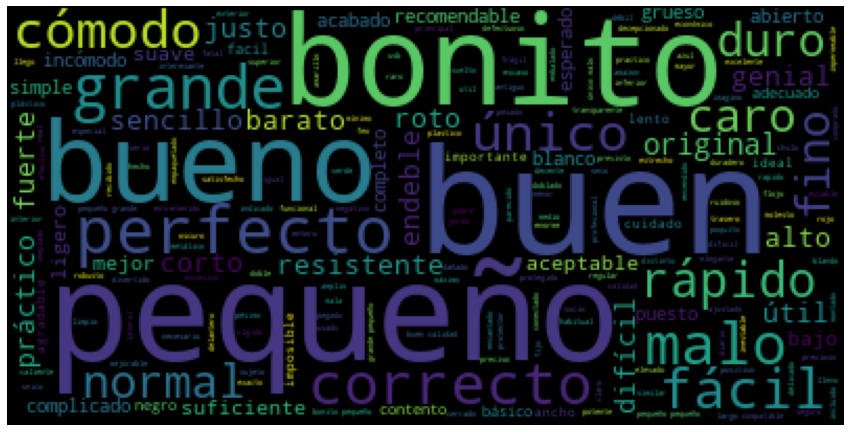

In [86]:
ver_wordcloud(todas_reviews_3)

In [87]:
# limpiamos memoria
gc.collect()

1451975

## Preprocesamiento
### Importamos el dataset de entrenamiento
Importamos dataset que será utilizado para *train* y nos quedamos con las columnas relevantes.

<span style='color:blue;'>**!! ACLARACIÓN:** En el notebook de "Procesamiento_de_datasets" se muestra el trabajo realizado para llegar a un único dataset filtrado por las columnas relevantes y que contengan también las lemmatizaciones y stemmizaciones de cada review concatenada a su título. **Ése es el set de datos que importamos para ahorrar tiempo de ejecución.**</span>

In [89]:
# Importamos dataset limpio
data = pd.read_json("dataset_amazon_clean.json", lines = False)
print("- Cantidad de filas total del set:", data.shape[0])
print("- Cantidad de filas nulas por columna:")
data.isna().sum()

- Cantidad de filas total del set: 210000
- Cantidad de filas nulas por columna:


product_category    0
review_title        0
review_body         0
stars               0
revs_lemma          0
revs_stem           0
dtype: int64

#### Importamos el dataset de prueba
Importamos dataset que será utilizado para *test* y nos quedamos con las columnas relevantes.

In [48]:
print("- Cantidad de filas total del set de prueba:", test_df.shape[0])
print("- Cantidad de filas nulas por columna:")
test_df.isna().sum()

- Cantidad de filas total del set de prueba: 5000
- Cantidad de filas nulas por columna:


product_category    0
review_title        0
review_body         0
stars               0
dtype: int64

### Tokenización 
Analizamos esta función de la librería spaCy con una review al azar.

In [90]:
# Miramos una review al azar
random_index = np.random.randint(0,data.shape[0])
review = data.review_body.iloc[random_index]
title = data.review_title.iloc[random_index]
print(random_index, title, '\n',review)
print('- Valoración:',data.stars[random_index])
print('- Categoría:', data.product_category[random_index])

177532 Muy moderno por la estética 
 Me gusta bastante este reloj y he comprado este modelo con sistema inteligente porque tenía ganas de pegar el salto y probar algo nuevo. Tiene un diseño muy moderno y sus materiales son de calidad, la correa es de una goma elástica bastante suave y su pantalla es táctil y responde muy bien. Se puede recibir notificaciones de todas las aplicaciones como Email, WhatsApp, Facebook, WeChat, mensajes y las llamadas teléfono, se puede medir tu ritmo cardiaca al hacer deporte, cambiar el diseño de la pantalla... Para cargar la batería trae una base con conector USB pero no puedo indicar el tiempo de carga ni la duración de la batería ya que aún no lo tengo controlado. Es un accesorio sencillo de usar pero muy completo para el día a día.
- Valoración: 5
- Categoría: sports


In [92]:
# Mostramos las POS de la review elegida
sent = nlp(review)
for token in sent:
    print(token,"-",token.pos_)

Me - PRON
gusta - VERB
bastante - ADV
este - DET
reloj - NOUN
y - CCONJ
he - AUX
comprado - VERB
este - DET
modelo - NOUN
con - ADP
sistema - NOUN
inteligente - ADJ
porque - SCONJ
tenía - VERB
ganas - NOUN
de - ADP
pegar - VERB
el - DET
salto - NOUN
y - CCONJ
probar - VERB
algo - PRON
nuevo - ADJ
. - PUNCT
Tiene - VERB
un - DET
diseño - NOUN
muy - ADV
moderno - ADJ
y - CCONJ
sus - DET
materiales - NOUN
son - AUX
de - ADP
calidad - NOUN
, - PUNCT
la - DET
correa - NOUN
es - AUX
de - ADP
una - DET
goma - NOUN
elástica - ADJ
bastante - ADV
suave - ADJ
y - CCONJ
su - DET
pantalla - NOUN
es - AUX
táctil - ADJ
y - CCONJ
responde - VERB
muy - ADV
bien - ADV
. - PUNCT
Se - PRON
puede - AUX
recibir - VERB
notificaciones - NOUN
de - ADP
todas - DET
las - DET
aplicaciones - NOUN
como - SCONJ
Email - PROPN
, - PUNCT
WhatsApp - PROPN
, - PUNCT
Facebook - PROPN
, - PUNCT
WeChat - PROPN
, - PUNCT
mensajes - NOUN
y - CCONJ
las - DET
llamadas - ADJ
teléfono - NOUN
, - PUNCT
se - PRON
puede - AUX
medir 

In [91]:
# Visualización
# from spacy import displacy
# displacy.serve(sent, style="dep")

### Lemmatizer
Analizamos esta función de la librería spaCy con la review al azar.

In [93]:
# Tokens lemmatizados de la review elegida
for token in sent:
    print(token,"-",token.lemma_)

Me - yo
gusta - gustar
bastante - bastante
este - este
reloj - reloj
y - y
he - haber
comprado - comprar
este - este
modelo - modelo
con - con
sistema - sistema
inteligente - inteligente
porque - porque
tenía - tener
ganas - gana
de - de
pegar - pegar
el - el
salto - salto
y - y
probar - probar
algo - algo
nuevo - nuevo
. - .
Tiene - tener
un - uno
diseño - diseño
muy - mucho
moderno - moderno
y - y
sus - su
materiales - material
son - ser
de - de
calidad - calidad
, - ,
la - el
correa - correa
es - ser
de - de
una - uno
goma - goma
elástica - elástico
bastante - bastante
suave - suave
y - y
su - su
pantalla - pantalla
es - ser
táctil - táctil
y - y
responde - responder
muy - mucho
bien - bien
. - .
Se - él
puede - poder
recibir - recibir
notificaciones - notificación
de - de
todas - todo
las - el
aplicaciones - aplicación
como - como
Email - Email
, - ,
WhatsApp - WhatsApp
, - ,
Facebook - Facebook
, - ,
WeChat - WeChat
, - ,
mensajes - mensaje
y - y
las - el
llamadas - llamado
teléfo

In [94]:
#Constante de signos de puntuación
import string
puntua = string.punctuation + '¡¿...'
excluded_pos = ['SCONJ','CCONJ','NUM','PUNCT','PRON','DET','ADP','AUX','X','PROPN']

In [95]:
#Función para limpieza de datos con lemmatizer
def text_data_lemma(sentence):
    doc = nlp(sentence)
    
    clean_tokens = []
    for token in doc:
        if (token.pos_ not in excluded_pos and str(token) not in stopwords_spacy): 
            temp = token.lemma_.strip()
            clean_tokens.append(temp.lower())
    
    return clean_tokens

In [100]:
# Lemmatizamos y filtramos la review escogida
print("[ REVIEW ORIGINAL ] :", review)
clean_review = text_data_lemma(review)
clean_review = " ".join(clean_review)
print("\n[ REVIEW LEMMATIZADA ] :", clean_review)

[ REVIEW ORIGINAL ] : Me gusta bastante este reloj y he comprado este modelo con sistema inteligente porque tenía ganas de pegar el salto y probar algo nuevo. Tiene un diseño muy moderno y sus materiales son de calidad, la correa es de una goma elástica bastante suave y su pantalla es táctil y responde muy bien. Se puede recibir notificaciones de todas las aplicaciones como Email, WhatsApp, Facebook, WeChat, mensajes y las llamadas teléfono, se puede medir tu ritmo cardiaca al hacer deporte, cambiar el diseño de la pantalla... Para cargar la batería trae una base con conector USB pero no puedo indicar el tiempo de carga ni la duración de la batería ya que aún no lo tengo controlado. Es un accesorio sencillo de usar pero muy completo para el día a día.

[ REVIEW LEMMATIZADA ] : gustar reloj comprar modelo sistema inteligente gana pegar salto probar tener diseño moderno material calidad correa goma elástico suave pantalla táctil responder recibir notificación aplicación mensaje llamado t

### Stemmizer
Analizamos esta función de la librería spaCy con la review al azar.

In [101]:
# Importamos objeto de nltk que nos permite stemmizar en español
from nltk.stem.snowball import SpanishStemmer
stemmer = SpanishStemmer()

In [102]:
# Porbamos el stemmer en review al azar
sent = nlp(review)
for token in sent:
    print(token,"-",token.pos_,"-",stemmer.stem(token.text))

Me - PRON - me
gusta - VERB - gust
bastante - ADV - bastant
este - DET - este
reloj - NOUN - reloj
y - CCONJ - y
he - AUX - he
comprado - VERB - compr
este - DET - este
modelo - NOUN - model
con - ADP - con
sistema - NOUN - sistem
inteligente - ADJ - inteligent
porque - SCONJ - porqu
tenía - VERB - ten
ganas - NOUN - gan
de - ADP - de
pegar - VERB - peg
el - DET - el
salto - NOUN - salt
y - CCONJ - y
probar - VERB - prob
algo - PRON - algo
nuevo - ADJ - nuev
. - PUNCT - .
Tiene - VERB - tien
un - DET - un
diseño - NOUN - diseñ
muy - ADV - muy
moderno - ADJ - modern
y - CCONJ - y
sus - DET - sus
materiales - NOUN - material
son - AUX - son
de - ADP - de
calidad - NOUN - calid
, - PUNCT - ,
la - DET - la
correa - NOUN - corre
es - AUX - es
de - ADP - de
una - DET - una
goma - NOUN - gom
elástica - ADJ - elast
bastante - ADV - bastant
suave - ADJ - suav
y - CCONJ - y
su - DET - su
pantalla - NOUN - pantall
es - AUX - es
táctil - ADJ - tactil
y - CCONJ - y
responde - VERB - respond
muy - A

In [103]:
# Función para limpieza de datos con stemmer
def text_data_stem(sentence):
    doc = nlp(sentence)
    
    clean_tokens = []
    for token in doc:
        if (token.pos_ not in excluded_pos and str(token) not in stopwords_spacy): 
            temp = stemmer.stem(token.text).strip()
            clean_tokens.append(temp.lower())
    
    return clean_tokens

In [104]:
# Filtramos y stemmizamos la review escogida
print("[ REVIEW ORIGINAL ] :", review)
clean_review = text_data_stem(review)
clean_review = " ".join(clean_review)
print("\n[ REVIEW STEMMIZADA ] :", clean_review)

[ REVIEW ORIGINAL ] : Me gusta bastante este reloj y he comprado este modelo con sistema inteligente porque tenía ganas de pegar el salto y probar algo nuevo. Tiene un diseño muy moderno y sus materiales son de calidad, la correa es de una goma elástica bastante suave y su pantalla es táctil y responde muy bien. Se puede recibir notificaciones de todas las aplicaciones como Email, WhatsApp, Facebook, WeChat, mensajes y las llamadas teléfono, se puede medir tu ritmo cardiaca al hacer deporte, cambiar el diseño de la pantalla... Para cargar la batería trae una base con conector USB pero no puedo indicar el tiempo de carga ni la duración de la batería ya que aún no lo tengo controlado. Es un accesorio sencillo de usar pero muy completo para el día a día.

[ REVIEW STEMMIZADA ] : gust reloj compr model sistem inteligent gan peg salt prob tien diseñ modern material calid corre gom elast suav pantall tactil respond recib notif aplic mensaj llam telefon med ritm cardiac deport cambi diseñ pan

In [105]:
gc.collect()

400

In [ ]:
# Agregamos columna al dataset
train_df['clean_revs'] = clean_reviews
train_df.head()

<span style='color:blue;'> *Como el proceso de lemmatizar y stemmizar las reviews ya está hecho y agregado al dataset, pasamos a lo siguiente: la vectorización.*</span>

## Vectorización
### Importar y crear vectorizador

In [106]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf_test = TfidfVectorizer()

In [ ]:
# Seleccionamos las columnas de interés LEMMA
df_lemm = data.loc[:,('revs_lemma','stars')]
df_lemm.head()

In [ ]:
# Seleccionamos las columnas de interés STEM
df_stem = data.loc[:,('revs_stem','stars')]
df_stem.head()

Probamos primero con las reviews **lemmatizadas**, pero bien podría cambiarse por las **stemmizadas**.

In [ ]:
list_revs = list(df_lemm['clean_rev'].values)
stars = df_lemm['stars'].values
#stars
#list_revs = [" ".join(w) for w in list_revs] # Juntamos las palabras en un solo string por cada fila
#list_revs

In [ ]:
matriz_revs = tfidf.fit_transform(list_revs)
matriz_revs

In [ ]:
matriz_revs.toarray()

In [ ]:
# Tomamos las palabras
all_words = tfidf.get_feature_names()
print("Palabras más usadas:",all_words[0:50])

In [ ]:
# Hacemos lo mismo con los datos de test
df_lemm = test_df.loc[:,('clean_rev','stars')]
list_test = list(df_lemm['clean_rev'].values)
matriz_test = tfidf_test.fit_transform(list_test)
stars_test = df_lemm['stars'].values

### Modelización

In [ ]:
X_train = matriz_revs.toarray()
y_train = stars
X_test = matriz_test.toarray()
y_test = stars_test

#from sklearn.model_selection import train_test_split
#xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def confusion(ytest,y_pred):
    names=["No Sarcastico","Sarcastico"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

### Naive Bayes

In [ ]:
nb = GaussianNB()
nb.fit(X_train,y_train)

print("acc : ", nb.score(X_test,y_test))

In [ ]:
y_pred = nb.predict(X_test)
confusion(y_test,y_pred)